# 08d – New Endoscopy Site Selection

This notebook identifies optimal new locations for endoscopy capacity to address areas with **Low** or **Marginal** access (i.e., <4.0 rooms per 100,000 people aged 50–74). We implement and compare two strategies:

---

## Spatial Clustering (DBSCAN or Hexbin)

**Plain English Description:**
This method identifies clusters of underserved LSOAs (based on location, population, and access score) using spatial clustering techniques like **DBSCAN** or **hexbin aggregation**. A new site is proposed at the centroid of each cluster.

**Rationale:**
- Targets groups of underserved areas rather than single extremes.
- Prioritises consistent spatial gaps, especially in rural or edge-of-region zones.
- Clustering avoids over-concentrating new sites in dense urban cores.

---

In [3]:
# ----------------------------------------------------------
# Step 0 – Imports and File Paths
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Set plot style
plt.style.use("seaborn-v0_8-whitegrid")

# Define base and sub-directory paths
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
raw_dir = os.path.join(data_dir, "raw")
proc_dir = os.path.join(data_dir, "processed", "endoscopy")

# Define input file paths
gpkg_path = os.path.join(raw_dir, "LSOA_5-year_segment_master.gpkg")
access_path = os.path.join(proc_dir, "lsoa_competition_access.gpkg")
travel_path = os.path.join(proc_dir, "travel_times_filtered.csv")
facilities_path = os.path.join(proc_dir, "facilities_with_geometry.gpkg")
travel_csv_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")

# Load data
access_gdf = gpd.read_file(access_path)
lsoa_gdf = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# CRS alignment
access_gdf = access_gdf.to_crs(lsoa_gdf.crs)

# Filter underserved LSOAs (Low or Marginal access)
underserved_gdf = access_gdf[access_gdf["access_flag"].isin(["Low", "Marginal", "No Access"])].copy()

# Merge geometry onto underserved areas
underserved_gdf = underserved_gdf.merge(
    lsoa_gdf,
    on="lsoa21cd",
    how="left"
)

# Merge geometry onto underserved areas
underserved_gdf = underserved_gdf.merge(
    lsoa_gdf,
    on="lsoa21cd",
    how="left"
)

# Set correct geometry column
underserved_gdf = underserved_gdf.set_geometry("geometry")

# Reproject to British National Grid for clustering
underserved_gdf = underserved_gdf.to_crs(epsg=27700)


# Preview
print(f"Underserved LSOAs loaded: {underserved_gdf.shape[0]}")
underserved_gdf[["lsoa21cd", "rooms_per_100k_competition", "access_flag"]].head()


Underserved LSOAs loaded: 2065


,lsoa21cd,rooms_per_100k_competition,access_flag
0,E01020484,2.295663,Low
1,E01020481,0.999220,Low
2,E01020482,2.295663,Low
3,E01020479,2.295663,Low
4,E01020478,2.295663,Low


## Step 1a – Preview Map of Underserved LSOAs (Low + Marginal Access)

Before applying DBSCAN clustering, we visualise the spatial distribution of underserved LSOAs across the NHS South West region.

This helps confirm:
- That underserved areas form potential clusters
- The spread across urban/rural settings
- Any edge effects (e.g. eastern boundary LSOAs near other NHS regions)

The map colours LSOAs by access flag (`Low`, `Marginal`) and overlays existing facility locations.


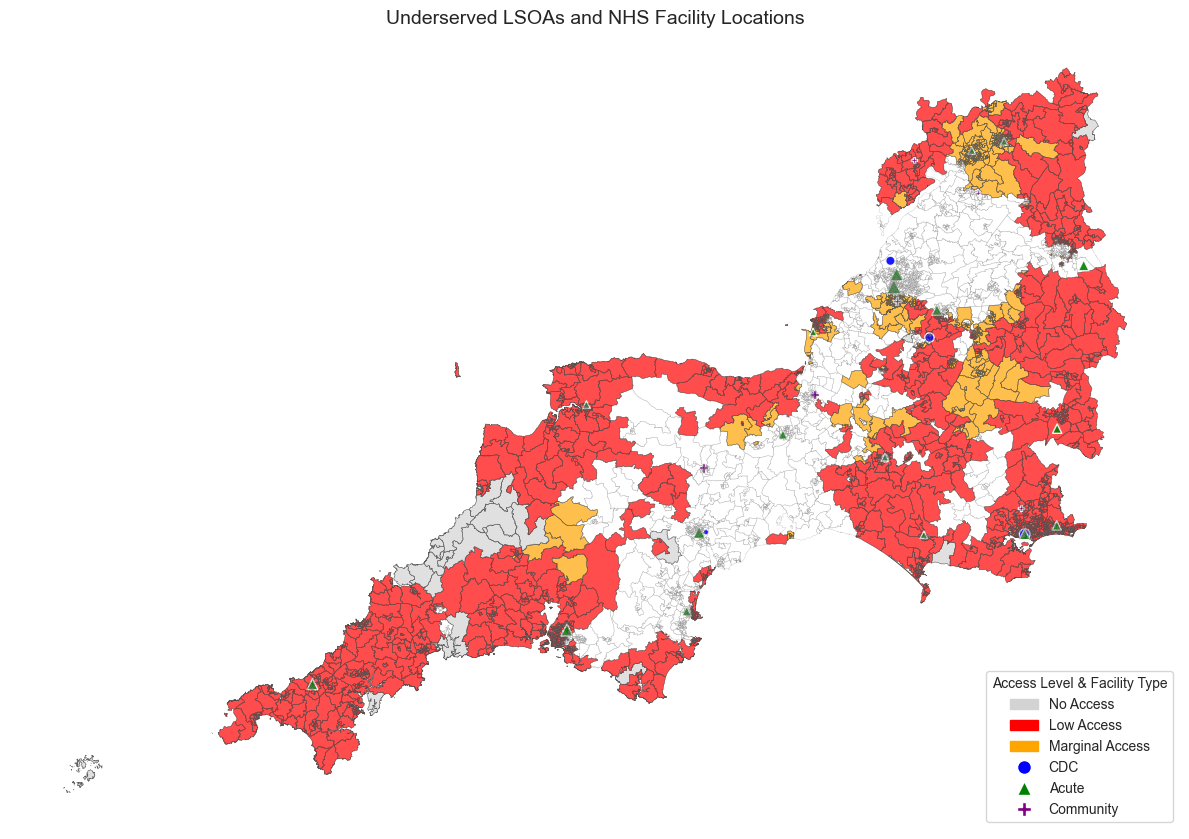

In [6]:
# ----------------------------------------------------------
# Step 1a – Visual Preview: Underserved LSOAs + NHS Facilities
# ----------------------------------------------------------

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Reproject facility and boundary data to match
facilities_gdf = gpd.read_file(facilities_path).to_crs(epsg=27700)
lsoa_borders = lsoa_gdf.to_crs(epsg=27700).boundary

# Create colour map for access types (No → Low → Marginal)
cmap = ListedColormap(["lightgrey", "red", "orange"])
access_order = ["No Access", "Low", "Marginal"]
access_code_map = {"No Access": 0, "Low": 1, "Marginal": 2}
underserved_gdf["access_code"] = underserved_gdf["access_flag"].map(access_code_map)

# Set up plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot underserved LSOAs (categorical)
underserved_gdf.plot(
    ax=ax,
    column="access_code",
    cmap=cmap,
    linewidth=0.3,
    edgecolor="black",
    alpha=0.7,
    legend=False
)

# Overlay LSOA borders
lsoa_borders.plot(
    ax=ax,
    linewidth=0.3,
    color="grey",
    alpha=0.4
)

# Overlay NHS facilities by type
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
    subset = facilities_gdf[facilities_gdf["source"] == label]
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 15,
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white"
    )

# Custom legend
access_patches = [
    mpatches.Patch(color='lightgrey', label='No Access'),
    mpatches.Patch(color='red', label='Low Access'),
    mpatches.Patch(color='orange', label='Marginal Access')
]
facility_handles = [
    plt.Line2D([0], [0], marker=mk, color='w', markerfacecolor=col, markersize=10, label=lbl)
    for lbl, col, mk in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]
]

ax.legend(
    handles=access_patches + facility_handles,
    title="Access Level & Facility Type",
    loc="lower right",
    frameon=True
)

# Final formatting
ax.set_title("Underserved LSOAs and NHS Facility Locations", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


## Step 2 – Apply DBSCAN to Identify Clusters of Underserved LSOAs

We apply DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to the underserved LSOAs, using their centroids as input coordinates.

**Key parameters**:
- `eps = 10,000` metres (10 km neighbourhood)
- `min_samples = 5` LSOAs to form a cluster

DBSCAN is well-suited for spatial clustering with:
- Irregular cluster shapes (urban & rural)
- Anomalies or isolated LSOAs near region edges


In [45]:
# ----------------------------------------------------------
# Step 2 – Filter, Cluster, and Package Underserved LSOAs
# ----------------------------------------------------------

from sklearn.cluster import DBSCAN
import numpy as np

# Parameters for cluster filtering
MIN_LSOA_PER_CLUSTER = 10
MAX_LSOA_PER_CLUSTER = 500  # Adjust based on diagnostics

# Filter for underserved LSOAs with at least some target-age population
filtered_gdf = underserved_gdf[underserved_gdf["pop_50_74"] > 0].copy()

# Convert to centroids and extract X/Y coords
filtered_gdf["centroid"] = filtered_gdf.geometry.centroid
coords = np.array(list(filtered_gdf["centroid"].apply(lambda p: (p.x, p.y))))

# Apply DBSCAN (10 km eps, min 5 LSOAs)
db = DBSCAN(eps=10_000, min_samples=5, metric="euclidean")
filtered_gdf["cluster"] = db.fit_predict(coords)

# Initial clustering result (excluding noise)
initial_clusters = filtered_gdf[filtered_gdf["cluster"] != -1].copy()

# Filter by cluster size
valid_clusters = []
for cluster_id, group in initial_clusters.groupby("cluster"):
    if MIN_LSOA_PER_CLUSTER <= len(group) <= MAX_LSOA_PER_CLUSTER:
        valid_clusters.append(group)

# Concatenate valid clusters into final GeoDataFrame
clustered_gdf = pd.concat(valid_clusters, ignore_index=True)

# Final summary
print(f"Total clusters after filtering: {clustered_gdf['cluster'].nunique()}")
print(f"LSOAs assigned to valid clusters: {clustered_gdf.shape[0]}")


Total clusters after filtering: 4
LSOAs assigned to valid clusters: 722


In [46]:
# ----------------------------------------------------------
# Step 2a – Store Per-Cluster LSOA Groupings
# ----------------------------------------------------------

# Build lookup dictionary for valid clusters
cluster_lsoa_lookup = {
    cluster_id: group.reset_index(drop=True)
    for cluster_id, group in clustered_gdf.groupby("cluster")
}

# Display sample cluster (only if it exists)
example_cluster = 1
if example_cluster in cluster_lsoa_lookup:
    print(f"\nExample – Cluster {example_cluster} Preview:")
    display(cluster_lsoa_lookup[example_cluster][["lsoa21cd", "pop_50_74", "access_flag"]].head())
else:
    print(f"\nCluster {example_cluster} not found in filtered results.")

print("Cluster sizes:")
for cid, group in cluster_lsoa_lookup.items():
    print(f"  Cluster {cid}: {len(group)} LSOAs")



Example – Cluster 1 Preview:


,lsoa21cd,pop_50_74,access_flag
0,E01014772,651.27,Marginal
1,E01014805,722.50,Marginal
2,E01014771,581.06,Low
3,E01014744,643.13,Marginal
4,E01014773,595.30,Low


Cluster sizes:
  Cluster 1: 94 LSOAs
  Cluster 2: 62 LSOAs
  Cluster 3: 471 LSOAs
  Cluster 4: 95 LSOAs


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_7659/2741170272.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = group.geometry.unary_union.centroid
/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_7659/2741170272.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = group.geometry.unary_union.centroid
/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_7659/2741170272.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = group.geometry.unary_union.centroid
/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_7659/2741170272.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = group.geometry.unary_union.centroid


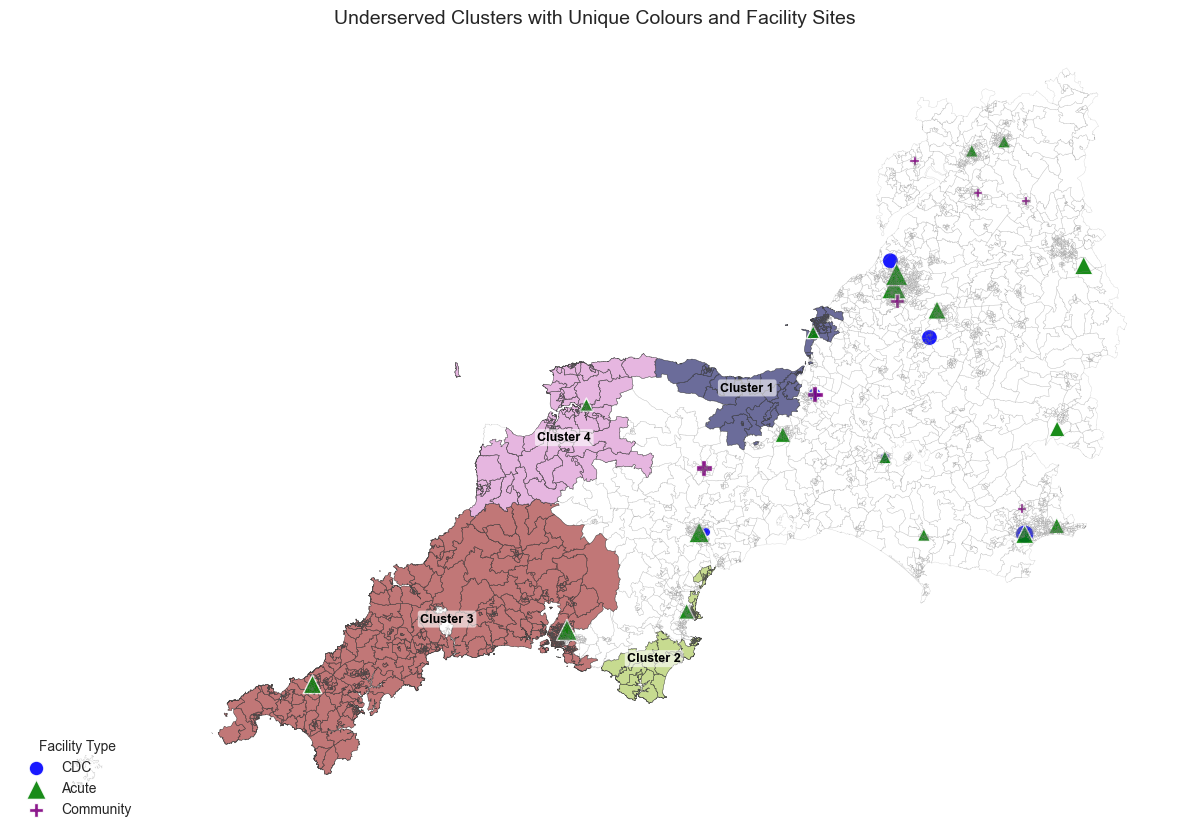

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Set up figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Sort clusters to ensure consistent colour assignment
sorted_clusters = sorted(clustered_gdf["cluster"].unique())
n_clusters = len(sorted_clusters)

# Assign a unique colour to each cluster using tab20 (or expand if > 20)
cmap = plt.get_cmap("tab20b", n_clusters)
cluster_colour_map = {
    cluster_id: cmap(i) for i, cluster_id in enumerate(sorted_clusters)
}

# Apply the colour map
clustered_gdf["cluster_colour"] = clustered_gdf["cluster"].map(cluster_colour_map)

# Plot LSOAs with assigned colours
clustered_gdf.plot(
    ax=ax,
    color=clustered_gdf["cluster_colour"],
    edgecolor="black",
    linewidth=0.3,
    alpha=0.75
)

# Add cluster labels at centroid
for cluster_id, group in clustered_gdf.groupby("cluster"):
    centroid = group.geometry.unary_union.centroid
    ax.text(
        centroid.x, centroid.y,
        f"Cluster {cluster_id}",
        fontsize=9,
        ha="center",
        va="center",
        fontweight="bold",
        color="black",
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2')
    )

# Add LSOA boundary base layer
lsoa_gdf.to_crs(epsg=27700).boundary.plot(
    ax=ax,
    linewidth=0.3,
    color="grey",
    alpha=0.3
)

# Plot facility markers
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
    subset = facilities_gdf[facilities_gdf["source"] == label].to_crs(epsg=27700)
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 45,
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white"
    )

# Finalise plot
ax.set_title("Underserved Clusters with Unique Colours and Facility Sites", fontsize=14)
ax.legend(title="Facility Type", loc="lower left")
ax.axis("off")
plt.tight_layout()
plt.show()


In [51]:
# ----------------------------------------------------------
# Step 2b – Identify Optimal LSOA per Cluster Using Travel Time
# ----------------------------------------------------------

# Load and prepare travel time matrix
travel_df = pd.read_csv(travel_csv_path)
travel_df["origin_name"] = travel_df["origin_name"].astype(str)
travel_df["destination_name"] = travel_df["destination_name"].astype(str)

# Containers for results and diagnostics
optimal_sites = []
skipped_clusters = []
cluster_sizes = {}

# Iterate through each cluster group
for cluster_id, df in cluster_lsoa_lookup.items():
    lsoa_ids = df["lsoa21cd"].tolist()
    cluster_sizes[cluster_id] = len(lsoa_ids)

    # Filter intra-cluster travel times (excluding self-to-self)
    cluster_travel = travel_df[
        (travel_df["origin_name"].isin(lsoa_ids)) &
        (travel_df["destination_name"].isin(lsoa_ids)) &
        (travel_df["origin_name"] != travel_df["destination_name"])
    ].copy()

    if cluster_travel.empty:
        print(f"Skipping cluster {cluster_id} – no valid travel pairs.")
        skipped_clusters.append(cluster_id)
        continue

    # Sum travel time from each origin to all others
    total_travel = (
        cluster_travel.groupby("origin_name")["travel_time_car"]
        .sum()
        .reset_index()
        .rename(columns={
            "origin_name": "lsoa21cd",
            "travel_time_car": "total_cluster_travel_time"
        })
    )

    # Filter out LSOAs with 0 total travel time (invalid optimals)
    valid_travel = total_travel[total_travel["total_cluster_travel_time"] > 0].copy()

    if valid_travel.empty:
        print(f"Skipping cluster {cluster_id} – all LSOAs have 0 total travel time.")
        skipped_clusters.append(cluster_id)
        continue

    # Select best LSOA
    best_lsoa = (
        valid_travel.merge(df, on="lsoa21cd", how="left")
        .sort_values("total_cluster_travel_time")
        .iloc[0]
    )

    optimal_sites.append({
        "cluster": cluster_id,
        "lsoa21cd": best_lsoa["lsoa21cd"],
        "travel_time_sum": best_lsoa["total_cluster_travel_time"],
        "pop_50_74": best_lsoa["pop_50_74"],
        "geometry": best_lsoa["geometry"]
    })

# ----------------------------------------------------------
# Output GeoDataFrame and Diagnostics
# ----------------------------------------------------------

optimal_sites_gdf = gpd.GeoDataFrame(optimal_sites, geometry="geometry", crs=clustered_gdf.crs)

# Display selected optimal LSOAs
print("\nOptimal LSOAs Selected:")
display(optimal_sites_gdf[["cluster", "lsoa21cd", "travel_time_sum", "pop_50_74"]])

# Summary diagnostics
print("\nSummary Diagnostics:")
print(f"Clusters processed: {len(cluster_lsoa_lookup)}")
print(f"Clusters skipped: {len(skipped_clusters)} → {skipped_clusters if skipped_clusters else 'None'}")

print("\nCluster Sizes:")
for cid, size in sorted(cluster_sizes.items()):
    print(f"  Cluster {cid}: {size} LSOAs")

print("\nTravel Time Distribution (seconds):")
print(optimal_sites_gdf["travel_time_sum"].describe().round(2))



Optimal LSOAs Selected:


,cluster,lsoa21cd,travel_time_sum,pop_50_74
0,1,E01014830,2595.493938,445.71
1,2,E01015214,1457.638024,470.13
2,3,E01018944,20782.161986,509.82
3,4,E01020124,2076.248392,526.09



Summary Diagnostics:
Clusters processed: 4
Clusters skipped: 0 → None

Cluster Sizes:
  Cluster 1: 94 LSOAs
  Cluster 2: 62 LSOAs
  Cluster 3: 471 LSOAs
  Cluster 4: 95 LSOAs

Travel Time Distribution (seconds):
count        4.00
mean      6727.89
std       9381.06
min       1457.64
25%       1921.60
50%       2335.87
75%       7142.16
max      20782.16
Name: travel_time_sum, dtype: float64


In [53]:
# Convert to DataFrame
optimal_sites_df = pd.DataFrame(optimal_sites)

# Join back to get centroid X/Y coordinates for each selected LSOA
optimal_sites_df = optimal_sites_df.merge(
    clustered_gdf[["lsoa21cd", "centroid"]], 
    on="lsoa21cd", 
    how="left"
)

# Extract X/Y for plotting
optimal_sites_df["centroid_x"] = optimal_sites_df["centroid"].apply(lambda p: p.x)
optimal_sites_df["centroid_y"] = optimal_sites_df["centroid"].apply(lambda p: p.y)


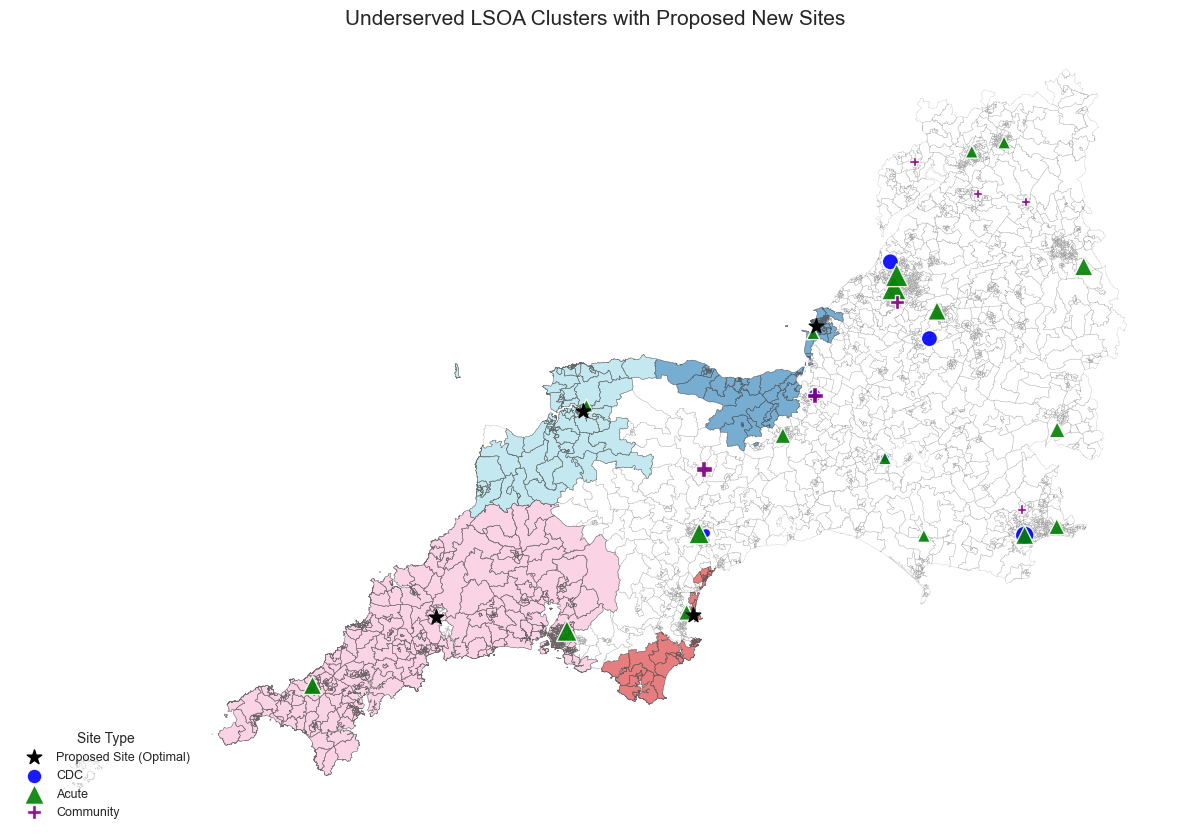

In [54]:
# ----------------------------------------------------------
# Step 2c – Map Optimal LSOA Sites onto Clusters
# ----------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# 1. Plot all clustered underserved LSOAs, coloured by cluster ID
clustered_gdf.plot(
    ax=ax,
    column="cluster",
    cmap="tab20",
    linewidth=0.3,
    edgecolor="black",
    legend=False,
    alpha=0.6
)

# 2. Plot proposed optimal LSOA sites
gpd.GeoDataFrame(
    optimal_sites_df,
    geometry=gpd.points_from_xy(optimal_sites_df["centroid_x"], optimal_sites_df["centroid_y"]),
    crs="EPSG:27700"
).plot(
    ax=ax,
    color="black",
    markersize=120,
    marker="*",
    label="Proposed Site (Optimal)",
    zorder=3
)

# 3. Plot current facility sites
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
    subset = facilities_gdf[facilities_gdf["source"] == label]
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 45,
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white",
        zorder=2
    )

# 4. Base map boundary
lsoa_gdf.to_crs(epsg=27700).boundary.plot(
    ax=ax,
    linewidth=0.3,
    color="grey",
    alpha=0.4,
    zorder=1
)

# 5. Formatting
ax.set_title("Underserved LSOA Clusters with Proposed New Sites", fontsize=15)
ax.axis("off")
ax.legend(loc="lower left", fontsize=9, title="Site Type")
plt.tight_layout()
plt.show()


In [56]:
# ----------------------------------------------------------
# Step 3 – Create Uplift File from Proposed Sites (Final Clusters)
# ----------------------------------------------------------

# 1. Load LSOA geometry source
lsoa_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]].to_crs(epsg=27700)

# 2. Merge geometries onto selected optimal sites
optimal_sites_df = optimal_sites_df.merge(
    lsoa_geom,
    on="lsoa21cd",
    how="left"
)

# 3. Convert to GeoDataFrame
proposed_gdf = gpd.GeoDataFrame(
    optimal_sites_df.copy(),
    geometry="geometry",
    crs="EPSG:27700"
)

# 4. Add standardised site attributes
proposed_gdf["Code"] = ["PROPOSED_" + str(i + 1) for i in proposed_gdf.index]
proposed_gdf["Name"] = "Proposed Site – Cluster " + proposed_gdf["cluster"].astype(str)
proposed_gdf["Endoscopy Rooms"] = 1
proposed_gdf["postcode"] = "TBC"
proposed_gdf["latitude"] = proposed_gdf.geometry.centroid.y
proposed_gdf["longitude"] = proposed_gdf.geometry.centroid.x
proposed_gdf["msoa21cd"] = "TBC"
proposed_gdf["oa21cd"] = "TBC"
proposed_gdf["icb_code"] = "TBC"
proposed_gdf["local_authority"] = "TBC"
proposed_gdf["source"] = "Proposed"

# 5. Reorder and clean columns
proposed_gdf = proposed_gdf[[
    "Code", "Name", "Endoscopy Rooms", "postcode",
    "latitude", "longitude", "lsoa21cd", "msoa21cd",
    "oa21cd", "icb_code", "local_authority", "source", "geometry"
]]

# 6. Final preview
print(f"Proposed uplift sites created: {proposed_gdf.shape[0]}")
display(proposed_gdf.head(2))


Proposed uplift sites created: 4


,Code,Name,Endoscopy Rooms,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority,source,geometry
0,PROPOSED_1,Proposed Site – Cluster 1,1,TBC,160640.790093,332575.445514,E01014830,TBC,TBC,TBC,TBC,Proposed,"MULTIPOLYGON (((332618 160974, 332624 160974, ..."
1,PROPOSED_2,Proposed Site – Cluster 2,1,TBC,64649.592036,291752.008878,E01015214,TBC,TBC,TBC,TBC,Proposed,"MULTIPOLYGON (((292020.064 64813.176, 292022.3..."


In [57]:
# 1. Concatenate original and proposed facilities
all_facilities_gdf = pd.concat(
    [facilities_gdf, proposed_gdf],
    ignore_index=True
)

# 2. Check result
print(f"Total combined facilities: {all_facilities_gdf.shape[0]}")
print(all_facilities_gdf["source"].value_counts())  # Should include 'CDC', 'Acute', 'Community', 'Proposed'


Total combined facilities: 36
source
Acute        18
CDC           7
Community     7
Proposed      4
Name: count, dtype: int64


In [58]:
# 1. Define output path
uplift_path = os.path.join(proc_dir, "facilities_with_proposed_sites.gpkg")

# 2. Save to GeoPackage
all_facilities_gdf.to_file(uplift_path, driver="GPKG")

# 3. Confirm write success
print(f"Combined facility file saved to: {uplift_path}")


Combined facility file saved to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/facilities_with_proposed_sites.gpkg
